In [1]:
%config InlineBackend.figure_format = 'retina' 

In [2]:
%run -n main.py
dotenv = dict(read_dotenv('.env'))
openai.api_key = dotenv['OPENAI_TOKEN']

In [3]:
%run -n main.py
label_client = label_studio_sdk.Client('http://localhost:8080', dotenv['LABELSTUDIO_TOKEN'])
label_client.check_connection()

{'status': 'UP'}

In [4]:
for label_project in label_client.list_projects():
    if label_project.title == 'rulm-sbs2':
        break
else:
    label_project = label_client.create_project(title='rulm-sbs2')

# sources

## alpaca

In [ ]:
!mkdir -p data/sources/alpaca
!curl -L https://github.com/yizhongw/self-instruct/raw/main/human_eval/user_oriented_instructions.jsonl \
    > data/sources/alpaca/user_oriented_instructions.jsonl

In [ ]:
%run -n main.py
items = read_jsonl('data/sources/alpaca/user_oriented_instructions.jsonl')
alpaca_items = list(parse_alpaca(items))

## vicuna

In [ ]:
!mkdir -p data/sources/vicuna
!curl -L https://github.com/lm-sys/vicuna-blog-eval/raw/main/eval/table/question.jsonl \
    > data/sources/vicuna/question.jsonl

In [ ]:
%run -n main.py
items = read_jsonl('data/sources/vicuna/question.jsonl')
vicuna_items = list(parse_vicuna(items))

## arena

In [ ]:
!mkdir -p data/sources/arena
!curl -L curl -L https://huggingface.co/datasets/lmsys/chatbot_arena_conversations/resolve/main/data/train-00000-of-00001-cced8514c7ed782a.parquet \
    > data/sources/arena/train-00000-of-00001-cced8514c7ed782a.parquet

In [ ]:
%run -n main.py
records = pd.read_parquet('data/sources/arena/train-00000-of-00001-cced8514c7ed782a.parquet').itertuples()
arena_items = list(parse_arena(records))

# orig

In [ ]:
orig_items = alpaca_items + vicuna_items

In [ ]:
instruction_items = {
    _['instruction']: _
    for _ in arena_items
    if _['lang'] == 'English'
}
orig_items.extend(random.sample(list(instruction_items.values()), 1000))

In [14]:
write_json('data/orig.json', orig_items)

In [15]:
orig_items = read_json('data/orig.json')
random.sample(orig_items, 5)

[{'id': 'c189117c-b2a1-4ac9-9f0e-06370cfe8b6b',
  'source': 'arena',
  'source_id': 'adccaf90b7904fdeb56a1da9150c2492',
  'lang': 'English',
  'instruction': 'Let\'s think about writing a Python script step by step. \n\n1) Analyze and define the use case. What does the script need to accomplish? \n\n2) Analyze the required parameters? What does it need to know? How can it get the parameters? \n\n3) Define functions for use cases.\n\n4) Execute the script if it is running as the main module.\n\nHere is an example script for saving a message to a file:\n\nimport os\n\ndef get_user_input():\n    message = input("Please enter your message: ")\n    file_name = input("Please enter the file name: ")\n    return message, file_name\n\ndef save_message_to_file(message, file_name):\n    with open(file_name, \'w\') as file:\n        file.write(message)\n    print(f"Message saved to {file_name}")\n\ndef main():\n    message, file_name = get_user_input()\n    save_message_to_file(message, file_name)

# tasks

In [581]:
task_items = read_json('data/tasks.json')

In [ ]:
task_items.extend(
    {
        'id': _['id'],
        'source': _['source'],
        'instruction': None,
        'category': None
    }
    for _ in orig_items
    if _['source'] == 'arena'
)

In [584]:
write_json('data/tasks.json', task_items)

# translate

In [ ]:
translate_items = [
    {
        'id': _['id'],
        'instruction': _['instruction'],
        'answer': None
    }
    for _ in orig_items
    if _['source'] == 'arena'
]
id_translate_items = {_['id']: _ for _ in translate_items}

## auto

In [ ]:
%run -n main.py
items = [_ for _ in translate_items if not _['answer']]
queue = iter(tqdm(items))
workers = [translate_worker(queue) for _ in range(10)]
await asyncio.gather(*workers);

## review

In [ ]:
%run -n main.py
label_project.set_params(label_config=LABEL_TRANSLATE_CONFIG)

In [ ]:
label_items = [
    translate_label_item(_)
    for _ in translate_items
    if not id_task_items[_['id']]['instruction']
]
random.choice(label_items)

In [ ]:
label_project.delete_all_tasks();
label_project.import_tasks(label_items);

In [ ]:
for label_item in translate_project.export_tasks():
    item = label_translate_item(label_item)
    id_task_items[item['id']]['instruction'] = item['answer']

# infer

In [734]:
%run -n main.py
infer_items = read_json('data/infer.json')

In [735]:
infer_items.extend(
    {
        'id': _['id'],
        'model': 'gigachat_2',
        'instruction': _['instruction'],
        'answer': None
    }
    for _ in task_items
    if _['category'] not in (None, 'bad')
)

In [749]:
write_json('data/infer.json', infer_items)

In [ ]:
items = [
    _ for _ in infer_items
    if _['model'] == 'yagpt_chat'
    if _['answer'] is not None
]
print('|items| =', len(items))

# random.shuffle(items)
for item in items[-10:]:
    if item['answer']:
        print(item['instruction'])
        print('----')
        print(item['answer'])
        print('---\n\n')

## turbo

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'turbo_2']
queue = iter(tqdm(items))
workers = [openai_infer_worker(queue, model='gpt-3.5-turbo-0613') for _ in range(20)]
await asyncio.gather(*workers);

## gpt4

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'gpt4_2']
queue = iter(tqdm(items))
workers = [openai_infer_worker(queue, model='gpt-4-0613', request_timeout=1200) for _ in range(20)]
await asyncio.gather(*workers);

## gigachat

In [ ]:
%run -n main.py
headers = dict(read_headers('.gigachat'))
gigachat_client = gigachat_client_init(headers)

# After ~5 min / 260 answers blocked for ~1 hour
# {'result': 'rejected', 'reason': 'UserBlocked', 'user_blocked_until': '2023-08-25T11:00:24+00:00'}

# "в полуавтоматическом режиме банят, если 3 временных бана, то могут опять решить забанить насовсем.
# Так что при временном бане лучше какое-то время  подождать."

# "из-за запросов типа "Люди умирают, когда их убивают, откуда это высказывание?". Цензор такое
# отлавливает сколько-то раз и во временный бан отправляет"

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'gigachat_2']
queue = iter(tqdm(items[:200]))
workers = [gigachat_infer_worker(gigachat_client, queue) for _ in range(2)]
await asyncio.gather(*workers);

## yagpt

In [100]:
lines = !~/yandex-cloud/bin/yc iam create-token
YAGPT_TOKEN = lines[0]

lines = !~/yandex-cloud/bin/yc resource-manager folder get --name default --format json
data = json.loads(''.join(lines))
YAGPT_FOLDER_ID = data['id']

# token expires every ~12 hours

In [101]:
%run -n main.py
yagpt_client = yagpt_client_init(YAGPT_TOKEN, YAGPT_FOLDER_ID)

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'yagpt_instruct']
queue = iter(tqdm(items))
limiter = Limiter(min_delay=1.2)
workers = [yagpt_infer_worker(yagpt_client, limiter, queue, mode='instruct') for _ in range(5)]
await asyncio.gather(*workers);

In [ ]:
%run -n main.py
items = [_ for _ in infer_items if _['answer'] is None and _['model'] == 'yagpt_chat']
queue = iter(tqdm(items))
limiter = Limiter(min_delay=1.2)
workers = [yagpt_infer_worker(yagpt_client, limiter, queue, mode='chat') for _ in range(5)]
await asyncio.gather(*workers);

# classify

In [575]:
classify_items = [
    {
        'id': _['id'],
        'instruction': _['instruction'],
        'category': _['category'],
        'max_sim': 0
    }
    for _ in task_items
]

## auto

In [532]:
id_embeddings = read_pickle('data/embeddings.pkl')

In [533]:
%run -n main.py
items = [
    _ for _ in classify_items
    if _['id'] not in id_embeddings
]
for index in tqdm(range(0, len(items), 64)):
    batch = items[index:index + 64]
    texts = [_['instruction'] for _ in batch]
    embeddings = openai_embed_batch(texts)
    for item, embedding in zip(batch, embeddings):
        id_embeddings[item['id']] = np.array(embedding)

0it [00:00, ?it/s]


In [ ]:
write_pickle('data/embeddings.pkl', id_embeddings)

In [566]:
target_items = [
    _ for _ in classify_items
    if _['category'] and _['category'] != 'bad'
]
items = [_ for _ in classify_items if not _['category']]

for item in tqdm(items):
    max_sim = 0
    for target_item in target_items:
        sim = cosine_sim(
            id_embeddings[item['id']],
            id_embeddings[target_item['id']]
        )
        if sim > max_sim:
            max_sim = sim
            item['category'] = target_item['category']
    item['max_sim'] = max_sim

100%|██████████| 194/194 [00:00<00:00, 343.57it/s]


## review

In [563]:
%run -n main.py
label_project.set_params(label_config=LABEL_CLASSIFY_CONFIG)

In [582]:
id_task_items = {_['id']: _ for _ in task_items}

id_model_answers = defaultdict(dict)
for item in infer_items:
    if item['answer']:
        id_model_answers[item['id']][item['model']] = item['answer']

In [577]:
%run -n main.py
label_items = []
for item in classify_items:
    if not item['max_sim']:
        continue

    if not item['category']:
        continue

    if id_task_items[item['id']]['source'] != 'alpaca':
        continue
        
    model_answers = id_model_answers[item['id']]
    label_item = classify_label_item(item, model_answers)

    label_items.append(label_item)

category_counts = Counter(_['category'] for _ in task_items)
label_items = sorted(label_items, key=lambda _: category_counts[_['data']['category']])
len(label_items)

161

In [578]:
label_project.delete_all_tasks();
label_project.import_tasks(label_items);

In [583]:
%run -n main.py
for label_item in label_project.export_tasks():
    item = label_classify_item(label_item)
    id_task_items[item['id']]['category'] = item['category']

# sbs

In [589]:
sbs_items = read_json('data/sbs.json')

In [590]:
id_task_items = {_['id']: _ for _ in task_items}

id_model_answers = defaultdict(dict)
for item in infer_items:
    id_model_answers[item['id']][item['model']] = item['answer']

key_sbs_items = {}
for item in sbs_items:
    key = item['id'], item['model_a'], item['model_b']
    key_sbs_items[key] = item

In [591]:
model_a = 'turbo_2'
for item in infer_items:
    id, model_b = item['id'], item['model']
    if model_a == model_b:
        continue

    if model_b not in ('gpt4_2', 'gigachat', 'yagpt_instruct'):
        continue

    key = id, model_a, model_b
    if key in key_sbs_items:
        continue

    answer_a = id_model_answers[id][model_a]
    answer_b = id_model_answers[id][model_b]
    if not answer_a or not answer_b:
        continue

    task_item = id_task_items[id]
    instruction = task_item['instruction']

    category = task_item['category']
    if not category or category == 'bad':
        continue

    sbs_items.append({
        'id': id,
        'model_a': model_a,
        'model_b': model_b,

        'instruction': instruction,
        'answer_a': answer_a,
        'answer_b': answer_b,

        'result': None
    })

In [598]:
write_json('data/sbs.json', sbs_items)

## auto

In [597]:
%run -n main.py
items = [_ for _ in sbs_items if not _['result']]
random.shuffle(items)
queue = iter(tqdm(items))
workers = [sbs_worker(queue) for _ in range(7)]
await asyncio.gather(*workers);

100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


## review

In [152]:
%run -n main.py
label_project.set_params(label_config=LABEL_SBS_CONFIG)

In [153]:
%run -n main.py
items = []
for item in sbs_items:
    if not item['result']:
        continue

    items.append(item)
    
random.shuffle(items)
label_items = [sbs_label_item(_) for _ in items]

len(label_items)

222

In [ ]:
label_project.delete_all_tasks();
label_project.import_tasks(label_items);

In [ ]:
%run -n main.py
for item in sbs_items:
    key = item['id'], item['model_a'], item['model_b']
    key_sbs_items[key] = item

for label_item in label_project.export_tasks():
    item = label_sbs_item(label_item)
    key = item['id'], item['model_a'], item['model_b']
    key_sbs_items[key]['result'] = item['result']

# plot

In [ ]:
Counter({'turbo_2': 835,
         'gpt4_2': 835,
         'gigachat': 835,
         'yagpt_instruct': 835,
         'yagpt_chat': 834,
         'yagpt_alisa': 175,
         'saiga2_7b': 175,
         'saiga2_13b': 175,
         'saiga2_70b': 175})

In [715]:
%run -n main.py
ids = {_['id'] for _ in sbs_items}

counts = Counter()
for item in infer_items:
    if item['id'] not in ids:
        continue

    if item['answer']:
        counts[item['model'], is_censor(item['answer'])] += 1
counts

Counter({('turbo_2', None): 530,
         ('gpt4_2', None): 530,
         ('yagpt_instruct', None): 530,
         ('yagpt_chat', None): 530,
         ('gigachat', None): 520,
         ('saiga2_7b', None): 175,
         ('saiga2_13b', None): 175,
         ('saiga2_70b', None): 175,
         ('yagpt_alisa', None): 162,
         ('yagpt_alisa', True): 13,
         ('gigachat', True): 10})

In [717]:
10 / 530 * 100

1.8867924528301887

## bar

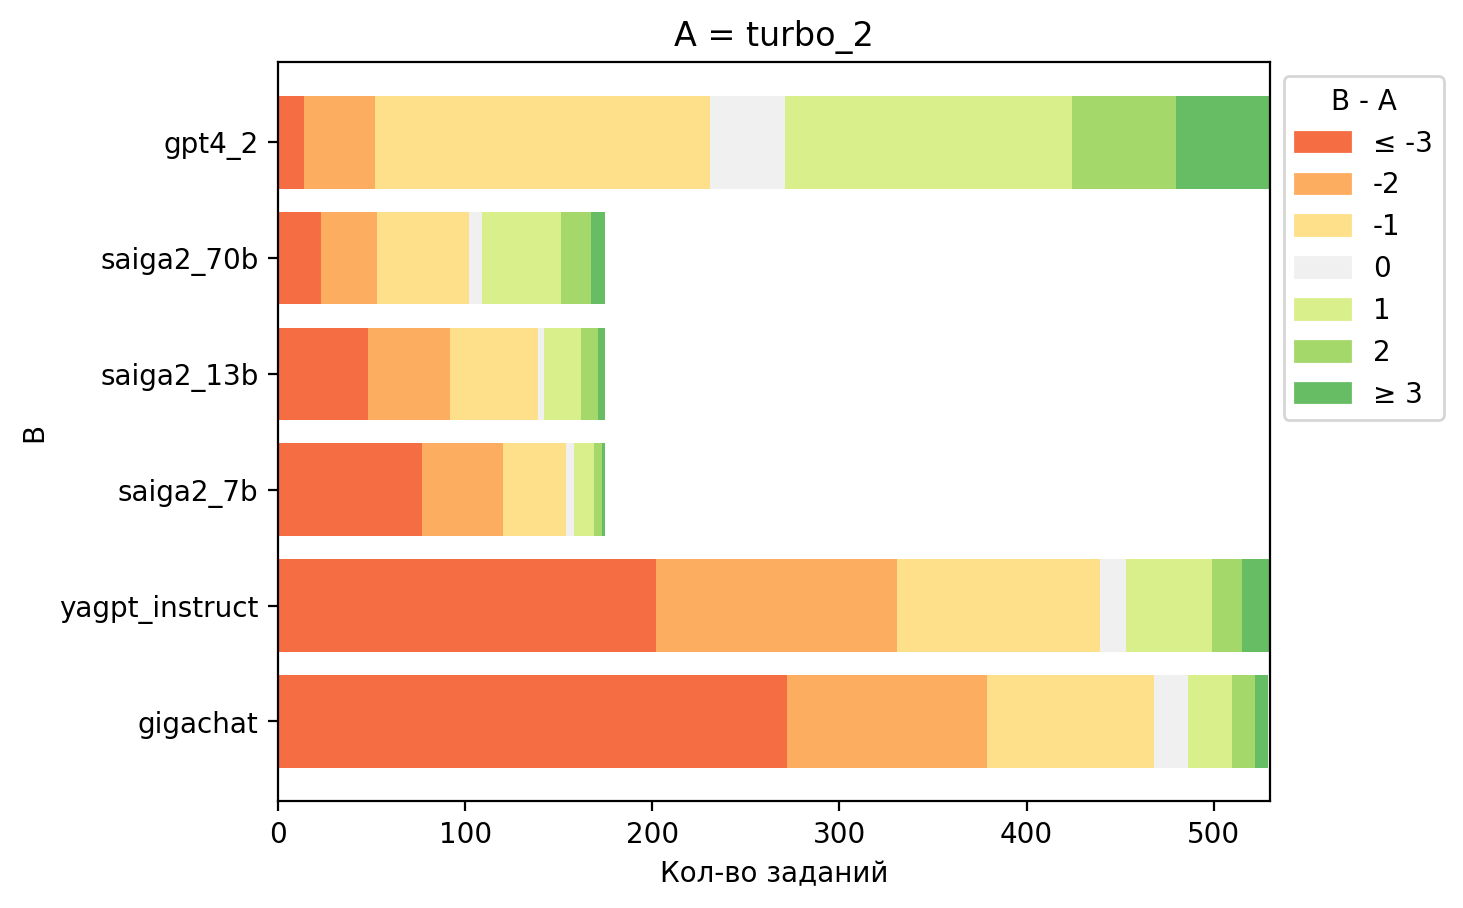

In [599]:
%run -n main.py
model_counts = Counter()
model_result_counts = defaultdict(Counter)
model_scores = Counter()
for item in sbs_items:
    result = item['result']
    if not result:
        continue
        
    score_a, score_b = item['score_a'], item['score_b']
    delta = abs(score_a - score_b)
    counts[delta] += 1
    if delta:
        if delta <= 1:
            delta = 1
        elif 1 < delta <= 2:
            delta = 2
        elif 2 < delta:
            delta = 3
        result = f'{result}{delta}'

    model = item['model_b']
    model_counts[model] += 1
    model_result_counts[model][result] += 1
    model_scores[model] += (score_b - score_a)

results_order = ['a3', 'a2', 'a1', 'tie', 'b1', 'b2', 'b3']
cmap = plt.get_cmap('RdYlGn')
colors = cmap(np.arange(0.2, 0.8, 0.7 / len(results_order)))
assert len(results_order) == len(colors)
result_colors = dict(zip(results_order, colors))
result_colors['tie'] = '#f0f0f0'

models_order = sorted(model_scores, key=model_scores.get)

fig, ax = plt.subplots()
ys, starts, widths, colors = [], [], [], []
for y, model in enumerate(models_order):
    start = 0
    for result in results_order:
        ys.append(y)
        width = model_result_counts[model][result]
        starts.append(start)
        widths.append(width)
        start += width
        color = result_colors[result]
        colors.append(color)

ax.barh(ys, widths, left=starts, color=colors)
ax.set_title('A = turbo_2')
ax.set_yticks(range(len(models_order)), models_order)
ax.set_ylabel('B')
ax.set_xlabel('Кол-во заданий')
ax.set_xlim(0, max(model_counts.values()))

result_labels = {
    'b3': '≥ 3',
    'b2': '2',
    'b1': '1',
    'tie': '0',
    'a1': '-1',
    'a2': '-2',
    'a3': '≤ -3'
}
handles = [
    mpatches.Patch(color=result_colors[_], label=result_labels[_])
    for _ in results_order
]
ax.legend(handles=handles, bbox_to_anchor=(1, 1), title='B - A')

## scatter

In [720]:
model_deltas = defaultdict(list)
for item in sbs_items:
    if not item['result']:
        continue

    score_a, score_b = item['score_a'], item['score_b']
    model_deltas[item['model_b']].append(score_b - score_a)

model_stats = {}
for model, deltas in model_deltas.items():
    samples = []
    for _ in range(500):
        sample_deltas = random.choices(deltas, k=len(deltas))
        sample = statistics.mean(sample_deltas)
        samples.append(sample)
        
    samples.sort()
    size = len(samples)
    model_stats[model] = {
        'median': samples[round(size / 2)],
        'lower_bound': samples[round(size * 0.05)],
        'upper_bound': samples[round(size * 0.95)],
    }
    
model_stats['turbo_2'] = {'median': 0, 'lower_bound': 0, 'upper_bound': 0}

Text(0.5, 0, 'Баллы B - баллы A')

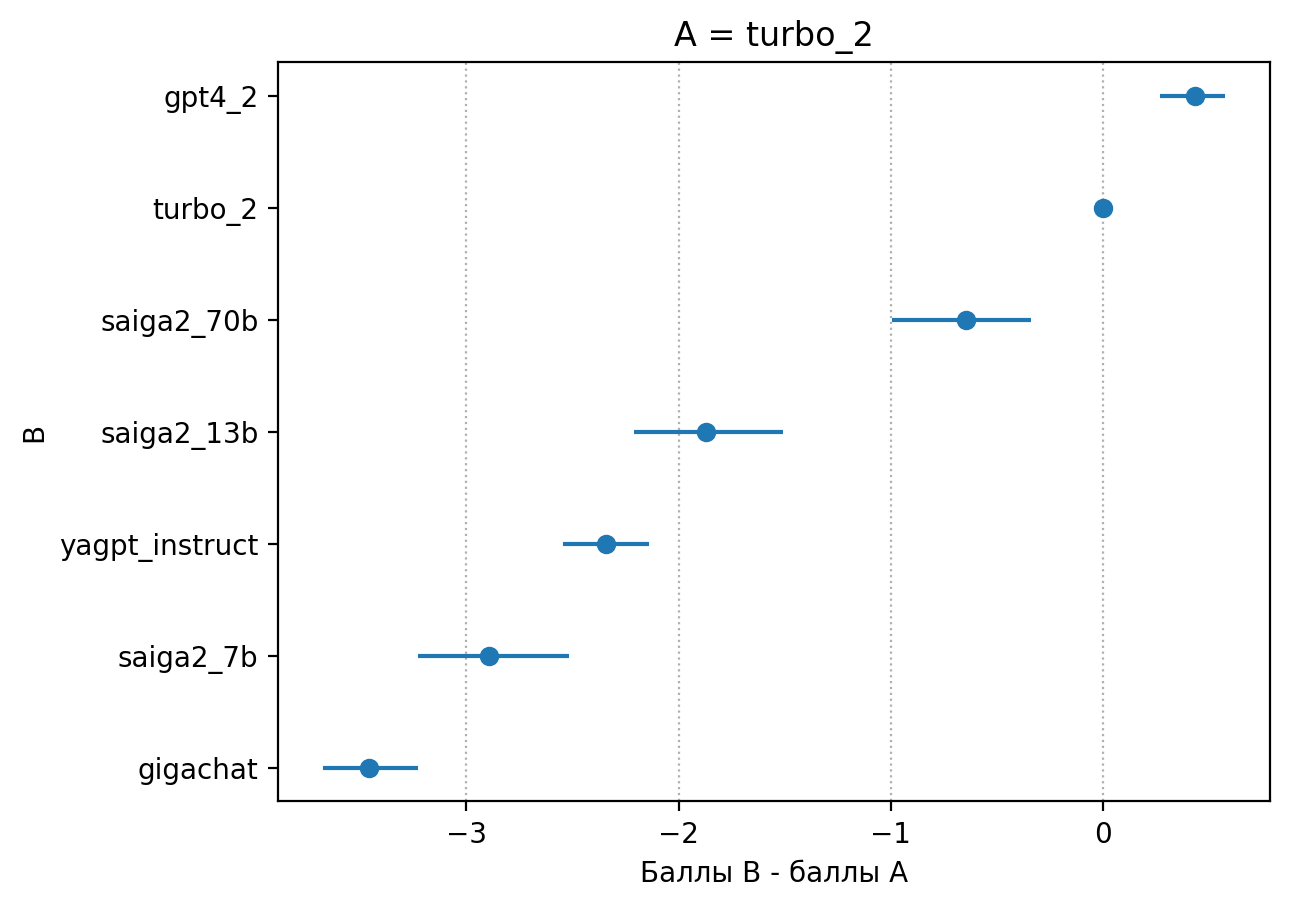

In [721]:
%run -n main.py
models_order = sorted(model_stats, key=lambda _: model_stats[_]['median'])

xs = []
ys = []
xerr_lower = []
xerr_upper = []
for y, model in enumerate(models_order):
    ys.append(y)

    stats = model_stats[model]
    xs.append(stats['median'])
    xerr_lower.append(stats['median'] - stats['lower_bound'])
    xerr_upper.append(stats['upper_bound'] - stats['median'])

fig, ax = plt.subplots()
ax.errorbar(
    x=xs,
    y=ys,
    xerr=[xerr_lower, xerr_upper],
    fmt='o'
)
ax.set_yticks(ys, models_order)
ax.xaxis.grid(linestyle=':')
ax.set_title('A = turbo_2')
ax.set_ylabel('B')
ax.set_xlabel('Баллы B - баллы A')

# polar categories

In [621]:
id_categories = {_['id']: _['category'] for _ in task_items}

category_mapping = {
    'writing': 'writing',
    'roleplay': 'roleplay',
    'brainstorm': 'brainstorm',
    'coding': 'coding',
    'math': 'math',
    'reason': 'reason',

    'enumerate': 'qa \n+ explain \n+ enumerate',
    'qa': 'qa \n+ explain \n+ enumerate',
    'explain': 'qa \n+ explain \n+ enumerate',

    'extract': 'extract \n+ summary',
    'summary': 'extract \n+ summary'
}

model_scores = Counter()
category_counts = Counter()
model_category_deltas = defaultdict(list)
for item in sbs_items:
    if not item['result']:
        continue

    category = id_categories[item['id']]
    category = category_mapping.get(category)
    if not category:
        continue
        
    model = item['model_b']
    score_a, score_b = item['score_a'], item['score_b']
    model_scores[model] += score_b
    category_counts[category] += 1
    delta = score_b - score_a
    model_category_deltas[model, category].append(delta)
    

model_category_stats = {}
for key, deltas in model_category_deltas.items():
    samples = []
    for _ in range(500):
        sample_deltas = random.choices(deltas, k=len(deltas))
        sample = statistics.mean(sample_deltas)
        samples.append(sample)
        
    samples.sort()
    size = len(samples)
    model_category_stats[key] = {
        'median': samples[round(size / 2)],
        'lower_bound': samples[round(size * 0.05)],
        'upper_bound': samples[round(size * 0.95)],
    }

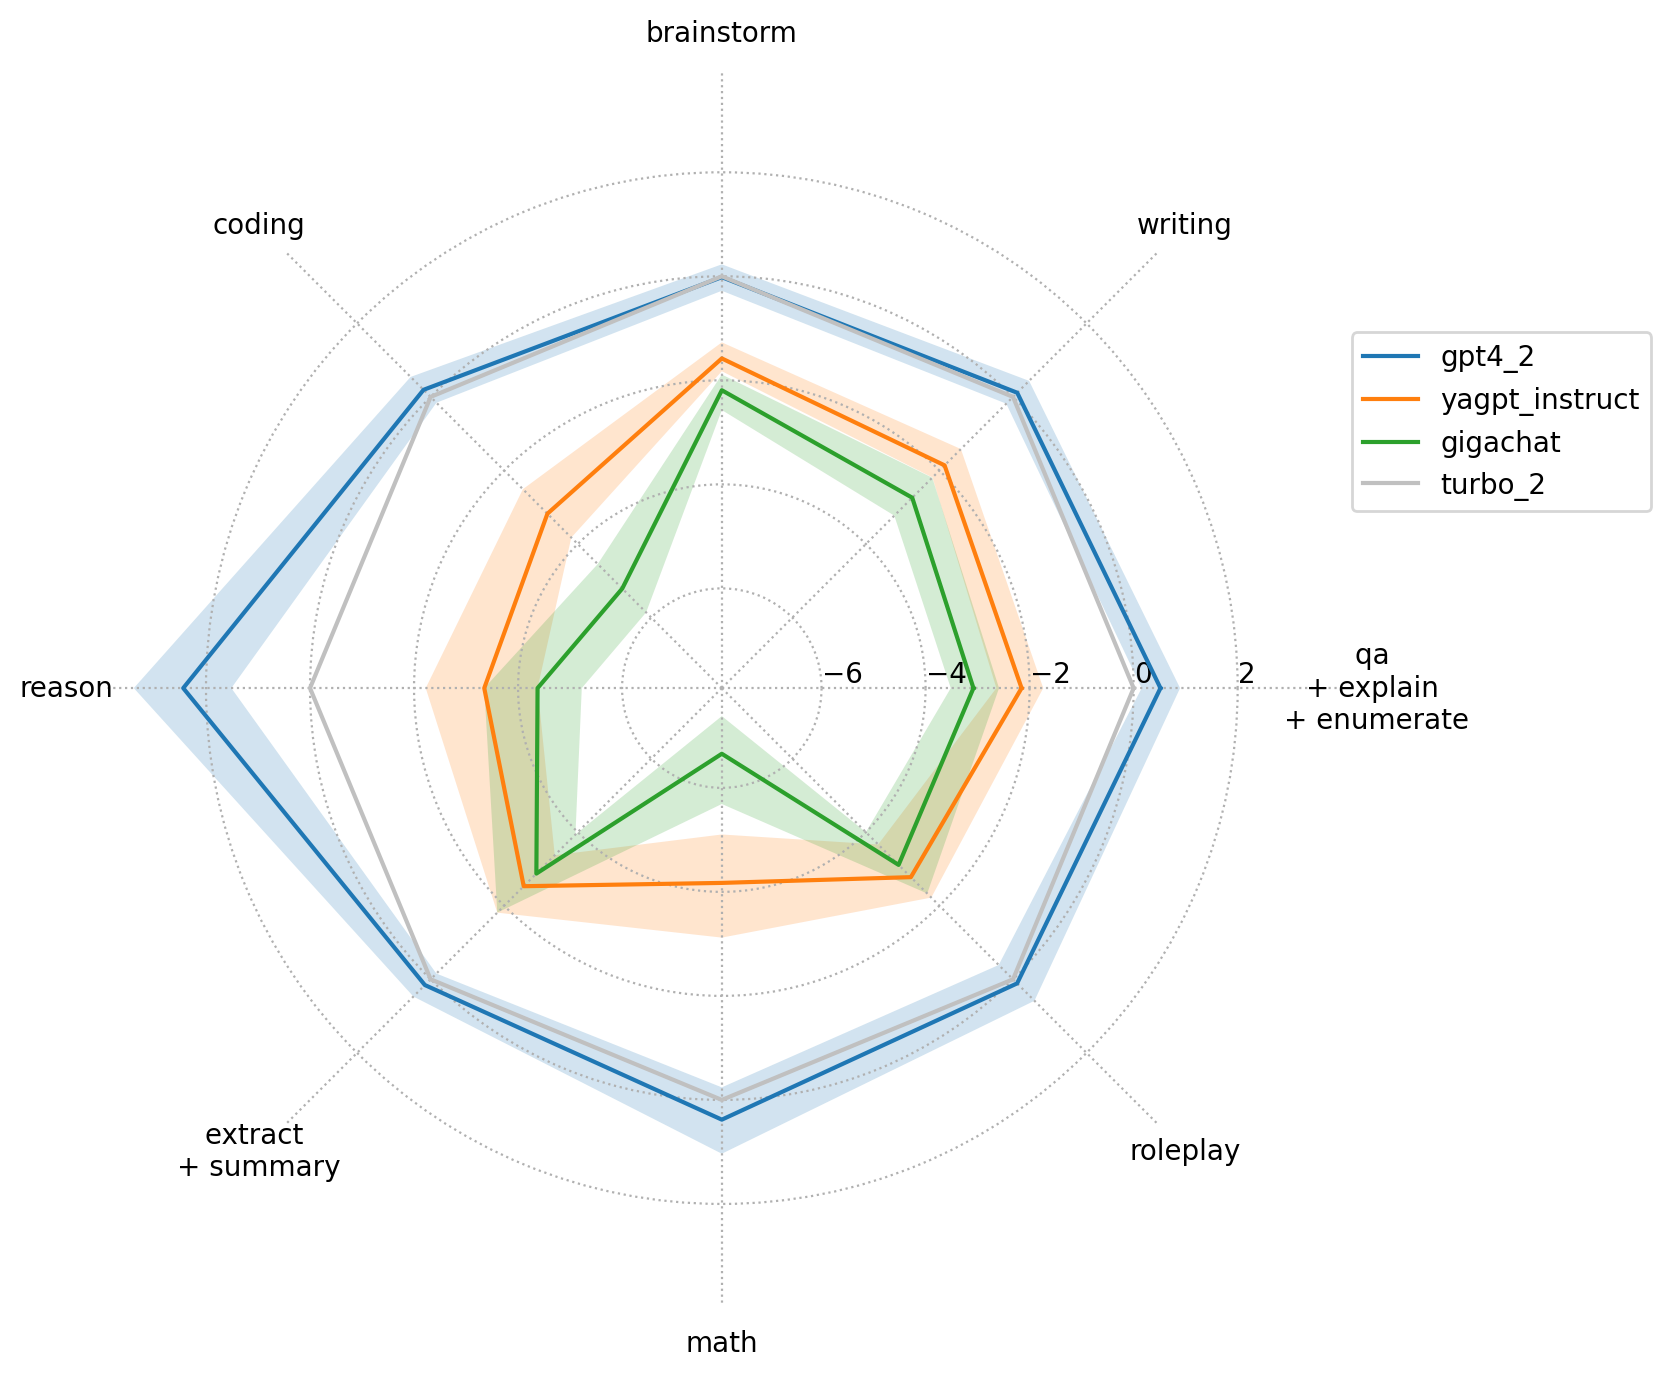

In [703]:

models_order = sorted(model_scores, key=model_scores.get, reverse=True)
models_order.append('turbo_2')

categories_order = sorted(category_counts, key=category_counts.get, reverse=True)
category_thetas = np.arange(0, 2 * np.pi, 2 * np.pi / len(categories_order))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for model in models_order:
    if model not in ('gpt4_2', 'gigachat', 'yagpt_instruct'):
        continue

#     if 'saiga' not in model:
#         continue

    rs, rs1, rs2 = [], [], []
    for category in categories_order:
        stats = model_category_stats[model, category]
        rs.append(stats['median'])
        rs1.append(stats['lower_bound'])
        rs2.append(stats['upper_bound'])

    thetas = category_thetas.copy()
    thetas = np.append(thetas, thetas[0])
    rs.append(rs[0])
    rs1.append(rs1[0])
    rs2.append(rs2[0])
    ax.plot(thetas, rs, label=model)
    ax.fill_between(thetas, rs1, rs2, alpha=0.2)

rs = [0 for _ in thetas]
ax.plot(thetas, rs, label='turbo_2', c='silver')

ax.spines.polar.set_visible(False)
ax.yaxis.grid(linestyle=':')
ax.xaxis.grid(linestyle=':')

ax.set_rlabel_position(0)
ax.set_xticks(category_thetas, categories_order)

ax.legend(bbox_to_anchor=(1, 0.8))
fig.set_size_inches(8, 8)

# show samples

## tasks

In [586]:
%run -n main.py
category_items = defaultdict(list)
for item in task_items:
    category = item['category'] or 'unlabeled'
    category = category.replace(' ', '_')
    if category == 'bad':
        continue

    category_items[category].append(item)

categories_order = sorted(
    category_items,
    key=lambda _: len(category_items[_]),
    reverse=True
)
categories_order.remove('unlabeled')
categories_order.append('unlabeled')

with open('data/tasks.md', 'w') as file:
    with redirect_stdout(file):
        print('<ul>')
        for category in categories_order:
            print(f'<li><a href="#{category}">{category}</a> — {len(category_items[category])}</li>')
        print('</ul>')

        for category in categories_order:
            print(f'<h1>{category}</h1>')

            items = [_ for _ in category_items[category]]
            random.shuffle(items)
            for item in items[:30]:
                print(f'<h5>{item["id"]}</h5>')
                instruction = html.escape(item['instruction'])
                print('<br/>\n'.join(instruction.splitlines()))
                print('<br/>')


## sbs

In [608]:
%run -n main.py
id_categories = {_['id']: _['category'] for _ in task_items}

model_items = defaultdict(list)
for item in sbs_items:
    model_items[item['model_b']].append(item)
    
with open('data/sbs.md', 'w') as file:
    with redirect_stdout(file):
        print('<ul>')
        for model in sorted(model_items):
            print(f'<li><a href="#{model}">{model}</a></li>')
        print('</ul>')

        for model in sorted(model_items):
            print(f'<h1>{model}</h1>')

            for item in random.sample(model_items[model], 20):
                print(f'<h3>{item["id"]}</h3>')
                print('<table>')
                print('<tr><td colspan="2">')
                category = id_categories[item['id']]
                if category:
                    print(f'#{category}')
                    print('<br/>')
                instruction = html.escape(item['instruction'])
                print('<br/>\n'.join(instruction.splitlines()))
                print('</td></tr>')

                print(f'<tr><td>turbo_2</td><td>{model}</td></tr>')
                print('<tr>')
                print('<td valign="top" width="50%">')
                answer_a = html.escape(item['answer_a'])
                print('<br/>\n'.join(answer_a.splitlines()))
                print('<br/>')
                print('</td>')
                print('<td valign="top" width="50%">')
                answer_b = html.escape(item['answer_b'])
                print('<br/>\n'.join(answer_b.splitlines()))
                print('</td>')
                print('</tr>')

                print('<tr><td colspan="2">')
                answer, model_a, model_b = item['answer'], item['model_a'], item['model_b']
                if item['swap']:
                    model_a, model_b = model_b, model_a
                answer = sbs_name_models(answer, model_a, model_b)
                answer = html.escape(answer)
                print('<br/>\n'.join(answer.splitlines()))
                print('</td></tr>')
                print('</table>')